In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 212 kB 49.3 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweets(data):
    tweets = [d['text'] for d in data]
    labels = [d['label'] for d in data]
    return tweets, labels

In [6]:
tweets, labels = get_tweets(train)

In [7]:
tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[2]])

[[17, 3060, 7, 1149, 5, 286, 2, 3, 495, 438]]

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets, max_len):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
  return padded

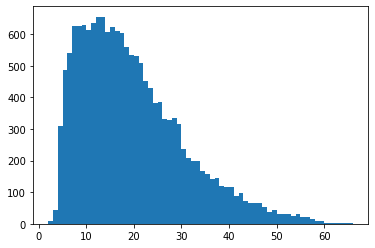

In [16]:
lengths = [len(tweet.split(' ')) for tweet in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets, 50)

In [19]:
padded_train_seq[2]

array([  17, 3060,    7, 1149,    5,  286,    2,    3,  495,  438,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [20]:
classes = set(labels)
print(classes)

{'anger', 'sadness', 'fear', 'love', 'joy', 'surprise'}


In [21]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [22]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[2])

0


In [45]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=50),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [40]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets, 50)
val_labels = names_to_ids(val_labels)

In [41]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [48]:
f = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 31s 62ms/step - loss: 1.2989 - accuracy: 0.4916 - val_loss: 0.8459 - val_accuracy: 0.6965
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.5614 - accuracy: 0.7998 - val_loss: 0.5973 - val_accuracy: 0.7985
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3213 - accuracy: 0.8931 - val_loss: 0.4563 - val_accuracy: 0.8530
Epoch 4/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2091 - accuracy: 0.9358 - val_loss: 0.4292 - val_accuracy: 0.8790
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1618 - accuracy: 0.9492 - val_loss: 0.5299 - val_accuracy: 0.8500
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1390 - accuracy: 0.9589 - val_loss: 0.3873 - val_accuracy: 0.8850
Epoch 7/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1045 - accuracy: 0.9688 - val_loss: 0.3864 - val_accuracy:

In [50]:
def show_history(f):
    epochs_trained = len(f.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), f.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), f.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), f.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), f.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


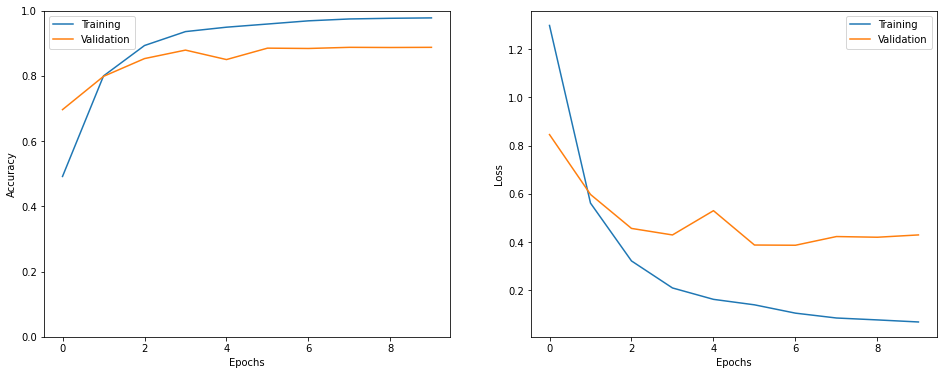

In [51]:
show_history(f)

In [54]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer,test_tweets,50)
test_labels = names_to_ids(test_labels)

In [55]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4559 - accuracy: 0.8815


In [58]:
i = random.randint(0,len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted emotion: ', pred_class)

Sentence:  i feel fucking woeful looking at the other girls
Emotion:  sadness
Predicted emotion:  joy


In [91]:
random_tweet = ['how happy they are about banning abortion is really disgusting']
emotion = 'anger'
predict = get_sequences(tokenizer,random_tweet,50)
p = model.predict(np.expand_dims(predict[0], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print(pred_class)

joy
